<a href="https://colab.research.google.com/github/TokaOssama/Volcanic-Eruption-Prediction/blob/main/DNN%20Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pandas as pd
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')
Data =  np.load('./drive/My Drive/Volcano Project/Saveddata.npy')
print(Data.shape)

Mounted at /content/drive
(4431, 10, 25, 202)


In [3]:
target_file = pd.read_csv ('./drive/My Drive/VolcanicData/train.csv')
target_file.head()

,segment_id,time_to_eruption
0,1136037770,12262005
1,1969647810,32739612
2,1895879680,14965999
3,2068207140,26469720
4,192955606,31072429


In [4]:
filename = []
for file in target_file['segment_id']:
    filename.append('./drive/My Drive/VolcanicData/train/'+str(file)+'.csv')
target_file['filename'] = filename
target_file= target_file.drop('segment_id',axis = 1)
target_file.head()

,time_to_eruption,filename
0,12262005,./drive/My Drive/VolcanicData/train/1136037770...
1,32739612,./drive/My Drive/VolcanicData/train/1969647810...
2,14965999,./drive/My Drive/VolcanicData/train/1895879680...
3,26469720,./drive/My Drive/VolcanicData/train/2068207140...
4,31072429,./drive/My Drive/VolcanicData/train/192955606.csv


In [5]:
x = target_file['filename']
Tags = np.array(target_file["time_to_eruption"])
print(Tags)

[12262005 32739612 14965999 ... 31206935  9598270 20128938]


In [6]:
Data=np.array(Data)
print(Data.shape)
Data = Data.reshape(4431, 10, 25, 202)
Data=np.transpose(Data,axes=[0,3,2,1])
print(Data.shape)
Data = np.concatenate((Data[:,:,:,0], Data[:,:,:,1], Data[:,:,:,2], Data[:,:,:,3], Data[:,:,:,4], Data[:,:,:,5], Data[:,:,:,6], Data[:,:,:,7], Data[:,:,:,8], Data[:,:,:,9]), axis=2 ) 
print(Data.shape)
Data_max=np.max(Data)
Data_min=np.min(Data)
Data = (Data-Data_min) / (Data_max-Data_min)


(4431, 10, 25, 202)
(4431, 202, 25, 10)
(4431, 202, 250)


In [7]:
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(Data, Tags, test_size=0.25, random_state=8)

x_valid, x_test, y_valid, y_test = train_test_split(x_valid, y_valid, test_size=0.25, random_state=1) 

print(x_train.shape)
print(y_train.shape)
print(x_valid.shape)
print(y_valid.shape)
print(x_test.shape)
print(y_test.shape)

(3323, 202, 250)
(3323,)
(831, 202, 250)
(831,)
(277, 202, 250)
(277,)


In [8]:
batch_size = 32
shuffle_buffer_size = 100

def create_dataset(series, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.shuffle(shuffle_buffer)
  dataset = dataset.batch(batch_size)
  #dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [9]:
dataset = create_dataset((x_train,y_train), batch_size, shuffle_buffer_size)
Validation_data = create_dataset((x_valid,y_valid), batch_size, shuffle_buffer_size)
#print(dataset.shape())

In [10]:
tf.random.set_seed(0)
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(256, activation="relu", input_shape=(202,250)), 
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.Dense(256, activation="relu"), 
    #tf.keras.layers.Dropout(0.2),
    #tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Dense(256, activation="relu"), 
    tf.keras.layers.Dense(256, activation="relu"), 
    
    #tf.keras.layers.Dropout(0.1),
    #tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation = 'relu'),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(1, activation = 'linear'),
    #tf.keras.layers.Dense(1)
])
optimizer = tf.keras.optimizers.Adam(0.1)
model.compile(loss="mae", optimizer=tf.keras.optimizers.Nadam(learning_rate=0.001))

In [11]:
#callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss')
history = model.fit(dataset,
         epochs=300,
         validation_data = Validation_data
                 
         )
train_loss = history.history['loss']
Validation_loss = history.history['val_loss']

Epoch 1/300
104/104 [==============================] - 60s 555ms/step - loss: 18433102.7524 - val_loss: 10273300.0000
Epoch 2/300
104/104 [==============================] - 59s 561ms/step - loss: 10493461.9905 - val_loss: 9010217.0000
Epoch 3/300
104/104 [==============================] - 59s 569ms/step - loss: 9224519.0762 - val_loss: 8199714.5000
Epoch 4/300
104/104 [==============================] - 59s 566ms/step - loss: 8219620.5810 - val_loss: 7688505.5000
Epoch 5/300
104/104 [==============================] - 59s 568ms/step - loss: 7684042.6095 - val_loss: 7051372.0000
Epoch 6/300
104/104 [==============================] - 59s 568ms/step - loss: 7356536.4048 - val_loss: 14021715.0000
Epoch 7/300
104/104 [==============================] - 59s 568ms/step - loss: 7103169.1571 - val_loss: 7386104.5000
Epoch 8/300
104/104 [==============================] - 60s 579ms/step - loss: 6787787.2238 - val_loss: 6287412.0000
Epoch 9/300
104/104 [==============================] - 61s 584ms/ste

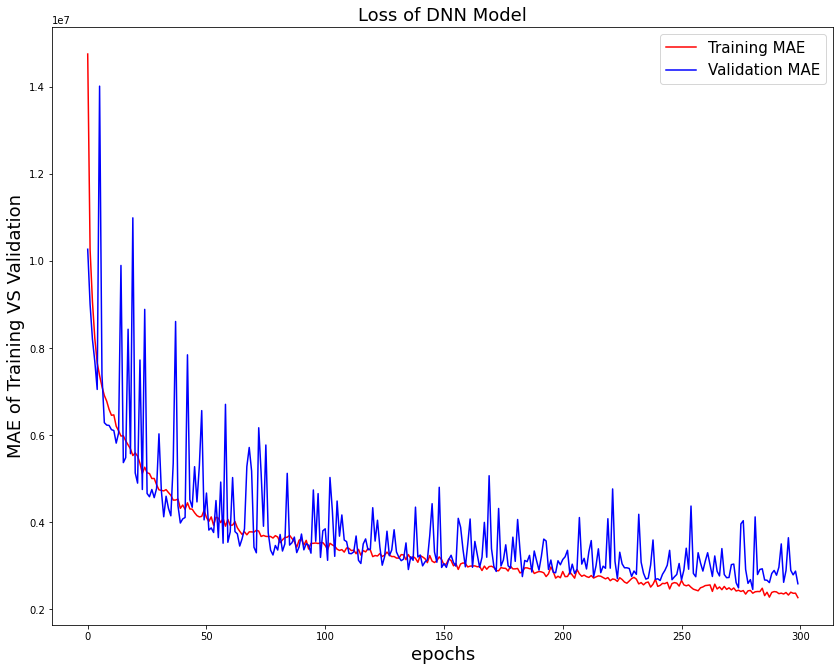

In [26]:
epochs = range(len(Validation_loss))
plt.figure(figsize=(14,11))
plt.plot(epochs, train_loss,'r',label='Training MAE')
plt.plot(epochs, Validation_loss,'B',label='Validation MAE')
plt.xlabel("epochs",fontsize=18)
plt.ylabel("MAE of Training VS Validation",fontsize=18)
plt.title('Loss of DNN Model',fontsize=18)
plt.legend(fontsize=15,loc='upper right')
plt.show()

In [14]:
model.evaluate(x_valid,y_valid)

26/26 [==============================] - 2s 72ms/step - loss: 2585667.7500


2585667.75

In [15]:
model.evaluate(x_test,y_test)

9/9 [==============================] - 1s 71ms/step - loss: 2611425.5000


2611425.5

In [16]:
y_pred = model.predict(x_test)
np.reshape(y_test,(-1,)).tolist()

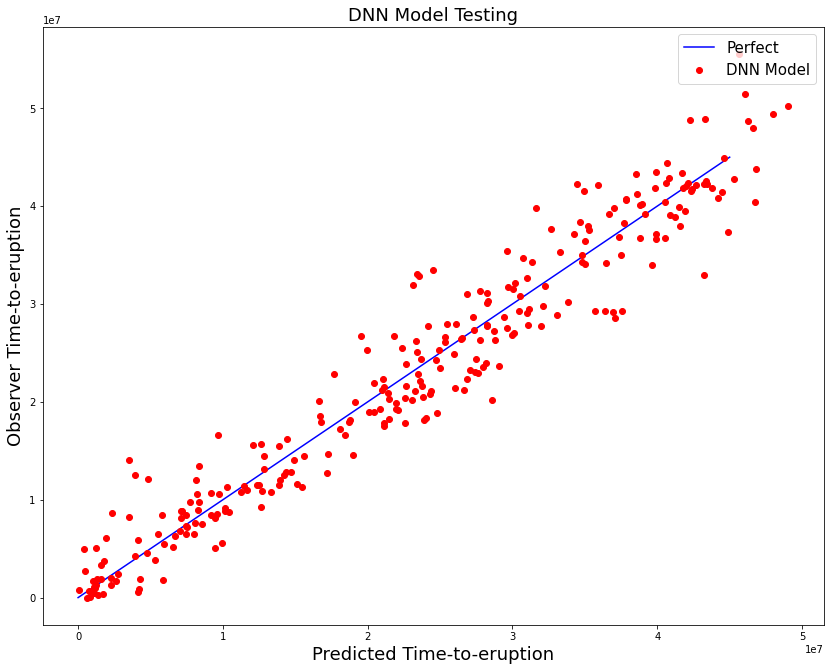

In [18]:
plt.figure(figsize=(14,11))
x = np.linspace(0,45*10**6)
y_pred = model.predict(x_test)
plt.plot(x,x,'b',linestyle='-',label='Perfect')
plt.plot(y_test,y_pred ,'r',linestyle='',marker='o',label='DNN Model')
plt.ylabel('Observer Time-to-eruption',fontsize=18)
plt.xlabel('Predicted Time-to-eruption',fontsize=18)
plt.title('DNN Model Testing',fontsize=18)
plt.legend(fontsize=15,loc='upper right')
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error,mean_absolute_error
MSE=mean_squared_error(results , y_valid)
MAE=mean_absolute_error(results , y_valid)

print(MSE)
print(MAE)

1.024967415063073
0.8710627361682313


In [19]:
Test_Data =  np.load('./drive/My Drive/Volcano Project/working.npy')
print(Test_Data.shape)

(4520, 10, 25, 202)


In [20]:
test_target_file = pd.read_csv ('./drive/My Drive/VolcanicData/sample_submission.csv')
test_target_file.head()

,segment_id,time_to_eruption
0,1000213997,0
1,100023368,0
2,1000488999,0
3,1001028887,0
4,1001857862,0


In [21]:
Test_filename = []
for file in test_target_file['segment_id']:
    Test_filename.append('./drive/My Drive/VolcanicData/test/'+str(file)+'.csv')
test_target_file['filename'] = Test_filename
test_target_file= test_target_file.drop('segment_id',axis = 1)
test_target_file.head()

,time_to_eruption,filename
0,0,./drive/My Drive/VolcanicData/test/1000213997.csv
1,0,./drive/My Drive/VolcanicData/test/100023368.csv
2,0,./drive/My Drive/VolcanicData/test/1000488999.csv
3,0,./drive/My Drive/VolcanicData/test/1001028887.csv
4,0,./drive/My Drive/VolcanicData/test/1001857862.csv


In [22]:
Test_Data=np.array(Test_Data)
print(Test_Data.shape)
Test_Data = Test_Data.reshape(4520, 10, 25, 202)
Test_Data=np.transpose(Test_Data,axes=[0,3,2,1])
print(Test_Data.shape)
Test_Data = np.concatenate((Test_Data[:,:,:,0], Test_Data[:,:,:,1], Test_Data[:,:,:,2], Test_Data[:,:,:,3], Test_Data[:,:,:,4], Test_Data[:,:,:,5], Test_Data[:,:,:,6], Test_Data[:,:,:,7], Test_Data[:,:,:,8], Test_Data[:,:,:,9]), axis=2 ) 
print(Test_Data.shape)
Test_Data_max=np.max(Test_Data)
Test_Data_min=np.min(Test_Data)
Test_Data = (Test_Data-Test_Data_min) / (Test_Data_max-Test_Data_min)


(4520, 10, 25, 202)
(4520, 202, 25, 10)
(4520, 202, 250)


In [23]:
Prediction = model.predict(Test_Data)
Prediction = pd.DataFrame(Prediction)
Prediction.to_csv(index=False)

'0\n25909114.0\n39661810.0\n16056290.0\n12888460.0\n13033500.0\n34070696.0\n34844052.0\n15687754.0\n842526.5\n7617452.5\n32474114.0\n22402818.0\n17326190.0\n17145830.0\n5719372.5\n10952482.0\n23715486.0\n26362672.0\n34490870.0\n10942119.0\n44935384.0\n6175053.0\n23938622.0\n26377826.0\n6123282.5\n28853350.0\n20568566.0\n1681606.4\n14380368.0\n20662348.0\n18352756.0\n19922022.0\n13249446.0\n6751331.0\n14638490.0\n39003816.0\n20472514.0\n13152026.0\n34454836.0\n26696450.0\n11044778.0\n7592304.0\n18894914.0\n12559378.0\n25641964.0\n51156960.0\n35869910.0\n30660826.0\n8182842.0\n48413610.0\n1798017.5\n29723642.0\n39483640.0\n5809166.0\n47201070.0\n29233726.0\n16027140.0\n-56161.195\n15092195.0\n21845662.0\n36579150.0\n27670462.0\n14305246.0\n14555998.0\n3057126.2\n12709576.0\n34619596.0\n6000871.0\n12559333.0\n11907232.0\n16254314.0\n17140706.0\n37188480.0\n20334160.0\n13032753.0\n47510652.0\n20217926.0\n42066796.0\n23960742.0\n20360438.0\n24529822.0\n19762576.0\n13957623.0\n38751340.0\n47